# Sensitivity analysis for non-parametric causal estimators
Sensitivity analysis helps us study how robust an estimated effect is when the assumption of no unobserved confounding is violated. That is, how much bias does our estimate have due to omitting  an (unobserved) confounder? Known as the 
*omitted variable bias (OVB)*, it gives us a measure of how the inclusion of an omitted common cause (confounder) would have changed the estimated effect. 

This notebook shows how to estimate the OVB for general, non-parametric causal estimators. For gaining intuition, we suggest going through an introductory notebook that describes how to estimate OVB for a a linear estimator: [Sensitivity analysis for linear estimators](https://github.com/py-why/dowhy/blob/master/docs/source/example_notebooks/sensitivity_analysis_testing.ipynb). To recap, in that notebook, we saw how the OVB depended on linear partial R^2 values and used this insight to compute the adjusted estimate values depending on the relative strength of the confounder with the outcome and treatment. We now generalize the technique using the non-parametric partial R^2 and Reisz representers.


This notebook is based on *Chernozhukov et al., Long Story Short: Omitted Variable Bias in Causal Machine Learning.  https://arxiv.org/abs/2112.13398*. 

## I. Sensitivity analysis for partially linear models
We first analyze the sensitivity of a causal estimate when the true data-generating process (DGP) is known to be partially linear. That is, the outcome can be additively decomposed into a linear function of the treatment and a non-linear function of the confounders. We denote the treatment by $T$, outcome by $Y$, observed confounders by $W$ and unobserved confounders by $U$. 
$$ Y = g(T, W, U) + \epsilon = \theta T + h(W, U) + \epsilon $$

However, we cannot estimate the above equation because the confounders $U$ are unobserved. Thus, in practice, a causal estimator uses the following "short" equation, 
$$ Y = g_s(T, W) + \epsilon_s = \theta_s T + h_s(W) + \epsilon_s $$

The goal of sensitivity analysis is to answer how far $\theta_s$ would be from the true $\theta$. Chernozhukov et al. show that given a special function called Reisz function $\alpha$, the omitted variable bias, $|\theta - \theta_s|$ is bounded by $\sqrt{E[g-g_s]^2E[\alpha-\alpha_s]^2}$. For partial linear models, $\alpha$ and the "short" $\alpha_s$  are defined as, 
$$ \alpha := \frac{T - E[T | W, U] )}{E(T - E[T | W, U]) ^ 2}$$
$$ \alpha_s := \frac{(T - E[T | W] )}{E(T - E[T | W]) ^ 2} $$

The bound can be expressed in terms of the *partial* R^2 of the unobserved confounder $U$ with the treatment and outcome, conditioned on the observed confounders $W$. Recall that R^2 of $U$ wrt some target $Z$ is defined as the ratio of variance of the prediction $E[Z|U]$ with the variance of $Z$, $R^2_{Z\sim U}=\frac{\operatorname{Var}(E[Z|U])}{\operatorname{Var}(Y)}$. We can define the partial R^2 as an extension that measures the additional gain in explanatory power conditioned on some variables $W$. 
$$ \eta^2_{Z\sim U| W} = \frac{\operatorname{Var}(E[Z|W, U]) - \operatorname{Var}(E[Z|W])}{\operatorname{Var}(Z) - \operatorname{Var}(E[Z|W])} $$

The bound is given by, 
$$ (\theta - \theta_s)^2 = E[g-g_s]^2E[\alpha-\alpha_s]^2 = S^2 C_Y^2 C_T^2 $$ 
where, 
$$ S^2 = \frac{E[(Y-g_s)^2]}{E[\alpha_s^2]}; \ \ C_Y^2 = \eta^2_{Y \sim U | T, W}, \ \ C_T^2 = \frac{\eta^2_{T\sim U | W}}{1 - \eta^2_{T\sim U | W}}$$


$S^2$ can be estimated from data. The other two parameters need to be specified manually: they convey the strength of the unobserved confounder $U$ on treatment and outcome. Below we show how to create a sensitivity contour plot by specifying a range of plausible values for $\eta^2_{Y \sim U | T, W}$ and $\eta^2_{T\sim U | W}$. We also show how to benchmark and set these values as a fraction of the maximum partial R^2 due to any subset of the observed covariates. 

### Creating a dataset with unobserved confounding 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Required libraries
import re
import numpy as np
import dowhy
from dowhy import CausalModel
import dowhy.datasets
from dowhy.utils.regression import create_polynomial_function

We create a dataset with linear relationship between treatment and outcome, following the partial linear data-generating process. $\beta$ is the true causal effect.

In [3]:
np.random.seed(101) 
data = dowhy.datasets.partially_linear_dataset(beta = 10,
                                               num_common_causes = 7,
                                               num_unobserved_common_causes=1,
                                               strength_unobserved_confounding=10,
                                               num_samples = 1000,
                                               num_treatments = 1,
                                               stddev_treatment_noise = 10,
                                               stddev_outcome_noise = 5
                                                )
display(data)

{'df':            W0        W1        W2        W3        W4        W5        W6  \
 0    0.345542  0.696984 -0.708658 -1.997165 -0.709139  0.165913 -0.554212   
 1   -0.075270  1.652779 -0.259591  0.282963 -0.764418  0.032002 -0.360908   
 2   -0.240272 -0.174564 -0.934469 -0.451650  1.959730  1.201015  0.471282   
 3    0.119874 -0.256127  0.318636 -0.223625  0.233940  1.549934 -0.763879   
 4    0.179436  1.410457 -0.635170 -1.263762  1.289872 -0.528325  0.122878   
 ..        ...       ...       ...       ...       ...       ...       ...   
 995  1.131240  0.084704 -1.837648 -0.250193 -0.774702 -0.466984 -0.979246   
 996 -0.581574  0.167608 -1.914603 -0.653232  2.027677  0.513934 -1.188357   
 997  0.009781  2.095094 -1.417172 -0.118229  1.953746  0.357782 -0.129897   
 998 -0.310415  0.410795 -0.205454 -0.818042  0.747265  1.235053  0.627017   
 999 -0.015367 -0.026768 -0.390476 -0.064762 -0.095389  0.911950  0.329420   
 
         v0          y  
 0     True   8.391102  
 1    

The true ATE for this data-generating process is,

In [4]:
data["ate"]

To simulate unobserved confounding, we remove one of the common causes from the dataset. 


In [5]:
# Observed data 
dropped_cols=["W0"]
user_data = data["df"].drop(dropped_cols, axis = 1)
# assumed graph
user_graph = data["gml_graph"]
for col in dropped_cols:
    user_graph = user_graph.replace('node[ id "{0}" label "{0}"]'.format(col), '')
    user_graph = re.sub('edge\[ source "{}" target "[vy][0]*"\]'.format(col), "", user_graph)
user_data

,W1,W2,W3,W4,W5,W6,v0,y
0,0.696984,-0.708658,-1.997165,-0.709139,0.165913,-0.554212,True,8.391102
1,1.652779,-0.259591,0.282963,-0.764418,0.032002,-0.360908,True,21.853491
2,-0.174564,-0.934469,-0.451650,1.959730,1.201015,0.471282,False,1.247109
3,-0.256127,0.318636,-0.223625,0.233940,1.549934,-0.763879,True,13.881250
4,1.410457,-0.635170,-1.263762,1.289872,-0.528325,0.122878,True,13.929866
...,...,...,...,...,...,...,...,...
995,0.084704,-1.837648,-0.250193,-0.774702,-0.466984,-0.979246,True,14.289693
996,0.167608,-1.914603,-0.653232,2.027677,0.513934,-1.188357,False,6.831359
997,2.095094,-1.417172,-0.118229,1.953746,0.357782,-0.129897,True,10.695485
998,0.410795,-0.205454,-0.818042,0.747265,1.235053,0.627017,False,-8.849379


### Obtaining a causal estimate using Model, Identify, Estimate steps
Create a causal model with the "observed" data and causal graph.

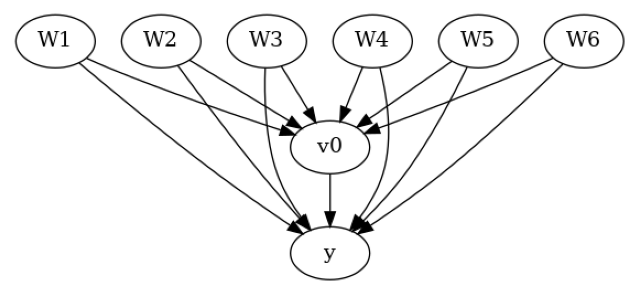

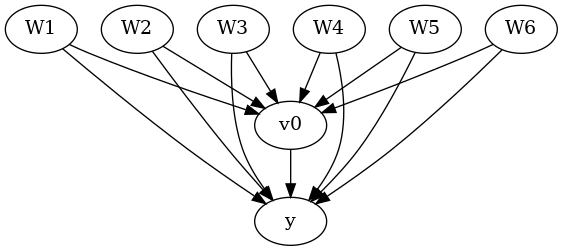

In [6]:
model = CausalModel(
            data=user_data,
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            graph=user_graph,
            test_significance=None,
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [7]:
# Identify effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W1,W6,W3,W4,W5,W2])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W6,W3,W4,W5,W2,U) = P(y|v0,W1,W6,W3,W4,W5,W2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [8]:
# Estimate effect
import econml
from sklearn.ensemble import GradientBoostingRegressor
linear_dml_estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.dml.LinearDML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'linear_first_stages': False
                                                       },
                                        'fit_params': {'cache_values': True,}
                                     })
print(linear_dml_estimate)

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-beh

2023-11-02 19:33:53.534664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-11-02 19:33:54.448436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W1,W6,W3,W4,W5,W2])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W6,W3,W4,W5,W2,U) = P(y|v0,W1,W6,W3,W4,W5,W2)

## Realized estimand
b: y~v0+W1+W6+W3+W4+W5+W2 | 
Target units: ate

## Estimate
Mean value: 11.689193432753717
Effect estimates: [[11.68919343]]



### Sensitivity Analysis using the Refute step
After estimation , we need to check how robust our estimate is against the possibility of unobserved confounders.  We perform sensitivity analysis for the LinearDML estimator assuming that its assumption on data-generating process holds: the true function for $Y$ is partial linear. For computational efficiency, we set <b>cache_values</b> = <b>True</b> in `fit_params` to cache the results of first stage estimation.

Parameters used:

* <b>method_name</b>: Refutation method name <br>
* <b>simulation_method</b>: "non-parametric-partial-R2" for non Parametric Sensitivity Analysis. 
Note that partial linear sensitivity analysis is automatically chosen if LinearDML estimator is used for estimation. 
* **partial_r2_confounder_treatment**: $\eta^2_{T\sim U | W}$, Partial R2 of unobserved confounder with treatment conditioned on all observed confounders. 
* **partial_r2_confounder_outcome**: $\eta^2_{Y \sim U | T, W}$, Partial R2 of unobserved confounder with outcome conditioned on treatment and all observed confounders. 

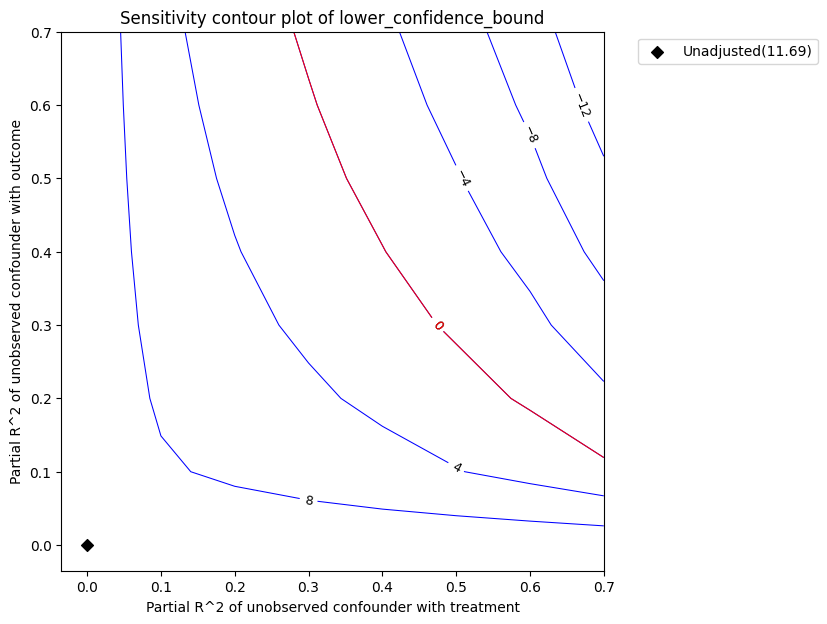

Sensitivity Analysis to Unobserved Confounding using partial R^2 parameterization

Original Effect Estimate : 11.689193432753717
Robustness Value : 0.44

Robustness Value (alpha=0.05) : 0.41000000000000003

Interpretation of results :
Any confounder explaining less than 44.0% percent of the residual variance of both the treatment and the outcome would not be strong enough to explain away the observed effect i.e bring down the estimate to 0 

For a significance level of 5.0%, any confounder explaining more than 41.0% percent of the residual variance of both the treatment and the outcome would be strong enough to make the estimated effect not 'statistically significant'




In [9]:
refute = model.refute_estimate(identified_estimand, linear_dml_estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulation_method = "non-parametric-partial-R2",
                               partial_r2_confounder_treatment = np.arange(0, 0.8, 0.1),
                               partial_r2_confounder_outcome = np.arange(0, 0.8, 0.1)
                              )
print(refute)

**Intepretation of the plot.** In the above plot, the x-axis shows hypothetical partial R2 values of unobserved confounder(s) with the treatment. The y-axis shows hypothetical partial R2 of unobserved confounder(s) with the outcome. At <x=0,y=0>, the black diamond shows the original estimate (theta_s) without considering the unobserved confounders.

The contour levels represent *adjusted* lower confidence bound estimate of the effect, which would be obtained if the unobserved confounder(s) had been included in the estimation model. The red contour line is the critical threshold where the adjusted effect goes to zero. Thus,  confounders with such strength or stronger are sufficient to reverse the sign of the estimated effect and invalidate the estimate's conclusions. This notion can be quantified by outputting the robustness value.

In [10]:
refute.RV

The robustness value measures the minimal equal strength of $\eta^2_{T\sim U | W}$ and $\eta^2_{Y \sim U | T, W}$ such the bound for the average treatment effect would include zero.  It can be between 0 and 1. <br>
A robustness value of 0.45 implies that confounders with $\eta^2_{T\sim U | W}$ and $\eta^2_{Y \sim U | T, W}$ values less than 0.4 would not be sufficient enough to bring down the estimates to zero. In general, a low robustness value implies that the results can be changed even by the presence of weak confounders whereas a robustness value close to 1 means the treatment effect can handle even strong confounders that may explain all residual variation of the treatment and the outcome.

**Benchmarking.** In general, however, providing a plausible range of partial R2 values is difficult. Instead,  we can infer the partial R2 of the unobserved confounder as a multiple of the partial R2 of any subset of observed confounders. So now we just need to specify the effect of unobserved confounding as a multiple/fraction of the observed confounding. This process is known as *benchmarking*.

The relevant arguments for bencmarking are:
- <b>benchmark_common_causes</b>: Names of the observed confounders used to bound the strengths of unobserved confounder<br>
- <b>effect_fraction_on_treatment</b>: Strength of association between unobserved confounder and treatment compared to benchmark confounders<br>
- <b>effect_fraction_on_outcome</b>: Strength of association between unobserved confounder and outcome compared to benchmark confounders<br>

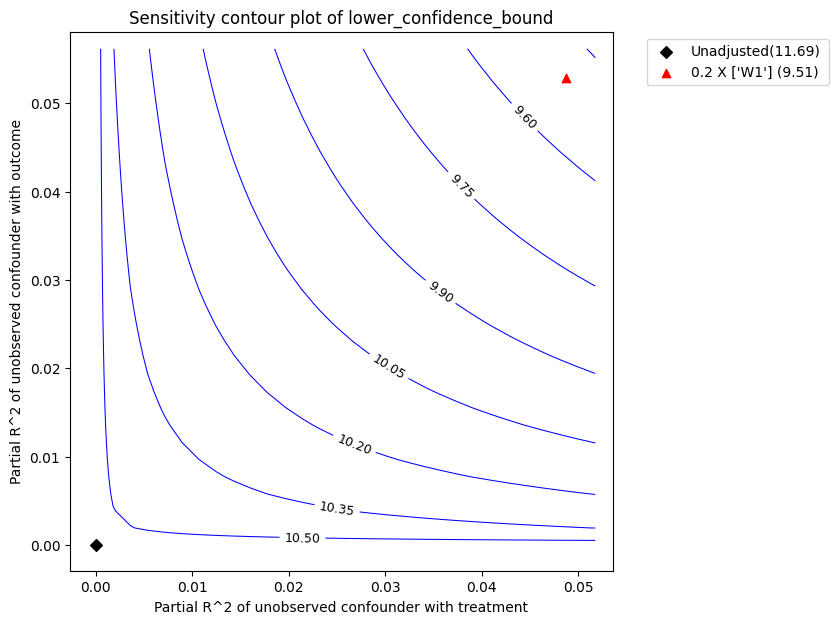

In [11]:
refute_bm = model.refute_estimate(identified_estimand, linear_dml_estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulation_method = "non-parametric-partial-R2",
                               benchmark_common_causes = ["W1"],
                               effect_fraction_on_treatment = 0.2,
                               effect_fraction_on_outcome = 0.2
                              )

The red triangle shows the estimated partial-R^2 of a chosen benchmark observed covariate with the treatment and outcome. In the above call, we chose *W1* as the benchmark covariate. Under assumption that the unobserved confounder cannot be stronger in its effect on treatment and outcome than the observed benchmark covariate (*W1*), the above plot shows that the mean estimated effect will reduce after accounting for unobserved confounding, but still remain substantially above zero.


**Plot types**. The default `plot_type` is to show the `lower_confidence_bound` under a significance level . Other possible values for the `plot_type` are:
* `upper_confidence_bound`: preferably used in cases where the unobserved confounder is expected to lower the estimate.
* `lower_ate_bound`: lower (point) estimate for unconfounded average treatment effect without considering the significance level
* `upper_ate_bound`: upper (point) estimate for unconfounded average treatment effect without considering the significance level
* `bias`: the bias of the obtained estimate compared to the true estimate

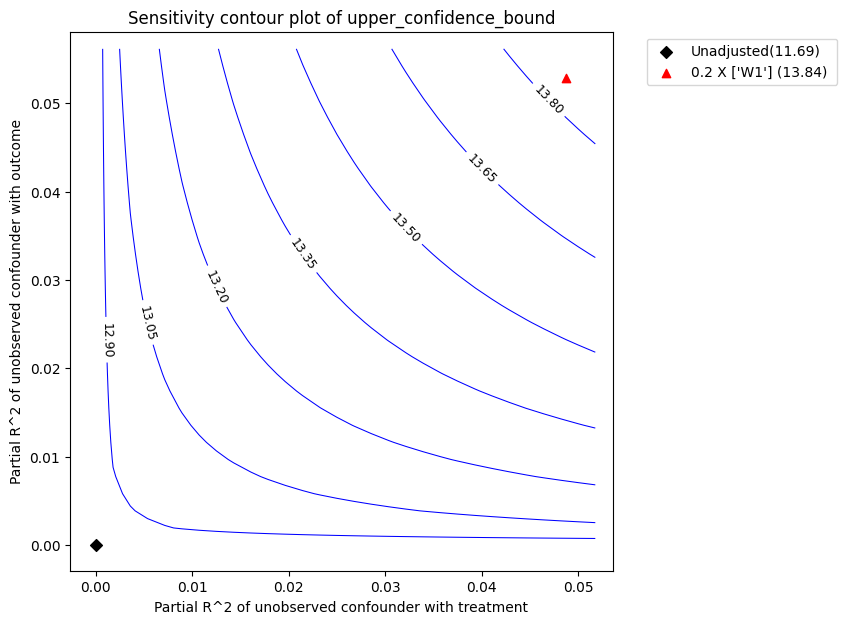

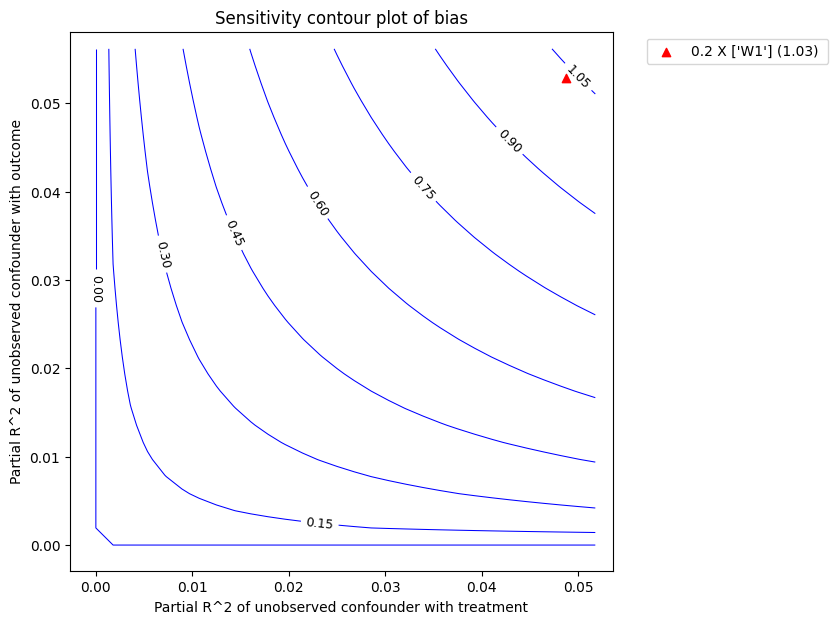

In [12]:
refute_bm.plot(plot_type = "upper_confidence_bound")
refute_bm.plot(plot_type = "bias")

We can also access the benchmarking results as a data frame.

In [13]:
refute_bm.results

,r2tu_w,r2yu_tw,short estimate,bias,lower_ate_bound,upper_ate_bound,lower_confidence_bound,upper_confidence_bound
0,0.0487,0.05281,11.689193,1.034078,10.655115,12.723272,9.508135,13.843394


## II. Sensitivity Analysis for general non-parametric models
We now perform sensitivity analysis without making any assumption on the true data-generating process. The sensitivity still depends on the partial R2 of unobserved confounder with outcome, $\eta^2_{Y \sim U | T, W}$, and a similar parameter for the confounder-treatment relationship. However,  the computation of bounds is more complicated and requires estimation of a special function known as reisz function. Refer to Chernozhukov et al. for details.

In [14]:
# Estimate effect using a non-parametric estimator
from sklearn.ensemble import GradientBoostingRegressor
estimate_npar = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.KernelDML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),                                                       },
                                        'fit_params': {},
                                     })
print(estimate_npar)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W1,W6,W3,W4,W5,W2])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W6,W3,W4,W5,W2,U) = P(y|v0,W1,W6,W3,W4,W5,W2)

## Realized estimand
b: y~v0+W1+W6+W3+W4+W5+W2 | 
Target units: ate

## Estimate
Mean value: 11.83216963161564
Effect estimates: [[11.83216963]]



To do the sensitivity analysis, we now use the same `non-parametric--partial-R2` method, however the estimation of partial R2 will be based on reisz representers. We use `plugin_reisz=True` to specify that we will be using a plugin reisz function estimator (this is faster and available for binary treatments). Otherwise, we can set it to `False` to estimate reisz function using a loss function.

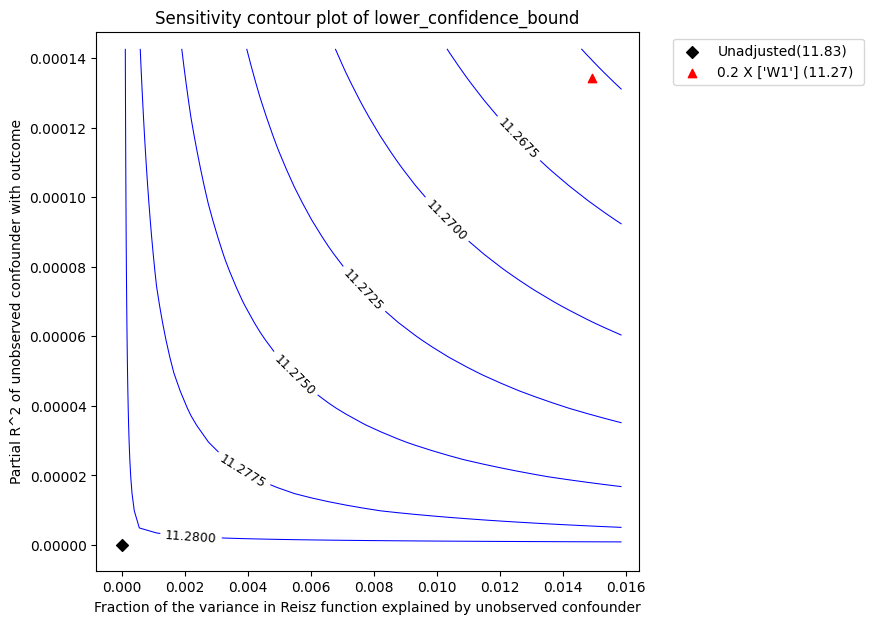

Sensitivity Analysis to Unobserved Confounding using partial R^2 parameterization

Original Effect Estimate : 11.83216963161564
Robustness Value : 0.66

Robustness Value (alpha=0.05) : 0.64

Interpretation of results :
Any confounder explaining less than 66.0% percent of the residual variance of both the treatment and the outcome would not be strong enough to explain away the observed effect i.e bring down the estimate to 0 

For a significance level of 5.0%, any confounder explaining more than 64.0% percent of the residual variance of both the treatment and the outcome would be strong enough to make the estimated effect not 'statistically significant'




In [15]:
refute_npar = model.refute_estimate(identified_estimand, estimate_npar,
                               method_name = "add_unobserved_common_cause",
                               simulation_method = "non-parametric-partial-R2",
                               benchmark_common_causes = ["W1"],
                               effect_fraction_on_treatment = 0.2,
                               effect_fraction_on_outcome = 0.2,
                               plugin_reisz=True
                              )
print(refute_npar)

The plot has the same interpretation as before. We obtain a robustness value of 0.66 compared to robustness value of 0.45 for LinearDML estimator.

Note that the robustness value changes, even though the point estimates from LinearDML and KernelDML are similar. This is because we made different assumptions on the true data-generating process.  